In [38]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import sys 
import warnings
import matplotlib.pyplot as plt
from shapely.geometry import mapping
import cartopy.crs as ccrs
import cartopy.feature
warnings.filterwarnings('ignore')
import time as timer
start_all = timer.time()

In [39]:
dataf ="/Volumes/ESA_F4R/era/" 
datao ="/Volumes/ESA_F4R/ed_prepare/" 
datap ="/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/plots/era/"
#data_all = "/Users/ellendyer/Desktop/1995/"

In [40]:
#For selection and plotting
YR = 2000
time_bnds = (str(YR)+'-01-01',str(YR)+'-12-31')
lon_bnds, lat_bnds = (7, 33), (13,-16)
lon_bnds_f, lat_bnds_f = (9, 31), (-14,11) 
p_bnds = (30000,100000)

**Read in ERA5 data on pressure levels (hourly timesteps in fortnightly files)**
- *fortnightly files currently run from 1994-2024*
- resampled to monthly MS timestep
- shum multiplied by 1000 to convert from kg/kg --> g/kg
- pressure levels are divided by 100 to convert from Pa to hPa (only for fortnightly files)
- sort data by descending pressure levels (only for fortnightly files)


**Input file units:**
- plev - pa
- q - kg/kg
- u - m/s
- v - m/s

In [41]:
start = timer.time()
from functools import partial
def _preprocess_pres(x, lon_bnds, lat_bnds, p_bnds):
    return x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds),
                 plev=slice(*p_bnds),drop=True)
partial_func_pres = partial(_preprocess_pres, lon_bnds=lon_bnds, lat_bnds=lat_bnds, p_bnds=p_bnds)

#Reading in pressure level variables from ERA5
ds_era_pres = xr.open_mfdataset(dataf+"era5/pressure_levels/era5_pressure_level_variables_central_africa_"+str(YR)+"*.nc",
                                drop_variables=['r','t','w'],
                                preprocess=partial_func_pres,parallel=True).resample(time='MS').mean(dim='time').load()
ds_era_pres = ds_era_pres.rename({'plev':'level','q':'Shum','u':'Uwnd','v':'Vwnd'})
ds_era_pres['Shum'] = 1000.0*ds_era_pres['Shum']
ds_era_pres['level'] = ds_era_pres['level']/100.0  
ds_era_pres = ds_era_pres.sortby('level', ascending=False) 
end = timer.time()
length = end - start
print("ERA5 pressure level data read in took ", length, "seconds")

ERA5 pressure level data read in took  1330.1439170837402 seconds


**Read in ERA5 land data (hourly in monthly files)**
- selecting hour 23 (0-23) of Prec and Evap because of how ERA5 Land variables are accumulated (https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790 - https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-accumulationsAccumulations)
- prec is multiplied by 1000 to convert from m to mm
- evap is multiplied by -1000 to convert from m to mm and upward fluxes in land model are considered negative
- Prec, Evap, and Psfc are then resampled to MS monthly and also interpolated to coarser pressure level grid

**Input file units:**
- tp - m
- e - m (-)
- sp - pa

In [42]:
start = timer.time()
from functools import partial
def _preprocess_land(x, lon_bnds, lat_bnds):
    x = x.sel(longitude=slice(*lon_bnds), latitude=slice(*lat_bnds),drop=True)
    return x
partial_func_land = partial(_preprocess_land, lon_bnds=lon_bnds, lat_bnds=lat_bnds)

#Reading in surface variables from ERA5 Land
ds_era_land = xr.open_mfdataset(dataf+"era5_land/era5_land_variables_central_africa_"+str(YR)+"*.nc",
                                drop_variables=['expver','number','pev','ssr','t2m'],
                                preprocess=partial_func_land,parallel=True).load()
ds_era_land = ds_era_land.rename({'valid_time':'time','latitude':'lat',
                                  'longitude':'lon','tp':'Prec','e':'Evap','sp':'Psfc'})
ds_era_land = ds_era_land.interp(lat=ds_era_pres['lat'],lon=ds_era_pres['lon'],method='linear',kwargs={"fill_value": "extrapolate"})
Prec = ds_era_land['Prec'].where(ds_era_land['time.hour']==23,drop=True)*1000.0
Evap_land = ds_era_land['Evap'].where(ds_era_land['time.hour']==23,drop=True)*-1000.0
Prec = Prec.resample(time='MS').mean(dim='time') 
Evap_land = Evap_land.resample(time='MS').mean(dim='time')
Psfc_land = ds_era_land['Psfc'].resample(time='MS').mean(dim='time')/100.0
ds_era_land.close()
end = timer.time()
length = end - start
print("ERA5 land data read in took ", length, "seconds")

ERA5 land data read in took  227.69362020492554 seconds


Read in ERA5 surface vars for merging

In [43]:
start = timer.time()

#Reading in surface variables from ERA5 surface files
ds_era_psfc = xr.open_mfdataset(dataf+"era5/era5_surface/era5_surface_pressure_central_africa_"+str(YR)+"*.nc",
                                drop_variables=['expver','number'],
                                preprocess=partial_func_land,parallel=True).load()
ds_era_psfc = ds_era_psfc.rename({'valid_time':'time','latitude':'lat',
                                  'longitude':'lon','sp':'Psfc'})
ds_era_psfc = ds_era_psfc.interp(lat=ds_era_pres['lat'],lon=ds_era_pres['lon'],method='linear',kwargs={"fill_value": "extrapolate"})
Psfc_surface = ds_era_psfc['Psfc'].resample(time='MS').mean(dim='time')/100.0
ds_era_psfc.close()

ds_era_evap = xr.open_mfdataset(dataf+"era5/era5_surface/era5_evaporation_central_africa_"+str(YR)+"*.nc",
                                drop_variables=['expver','number'],
                                preprocess=partial_func_land,parallel=True).load()
ds_era_evap = ds_era_evap.rename({'valid_time':'time','latitude':'lat',
                                  'longitude':'lon','e':'Evap'})
ds_era_evap = ds_era_evap.interp(lat=ds_era_pres['lat'],lon=ds_era_pres['lon'],method='linear',kwargs={"fill_value": "extrapolate"})
Evap = ds_era_evap['Evap'].resample(time='D').sum(dim='time')*-1000.0
Evap_surface = Evap.resample(time='MS').mean(dim='time')
ds_era_evap.close()

Evap = Evap_land.combine_first(Evap_surface)
Psfc = Psfc_land.combine_first(Psfc_surface)

length = end - start
print("ERA5 surface data read in took ", length, "seconds")

ERA5 surface data read in took  -0.20329499244689941 seconds


## Plotting the different evaporation arrays

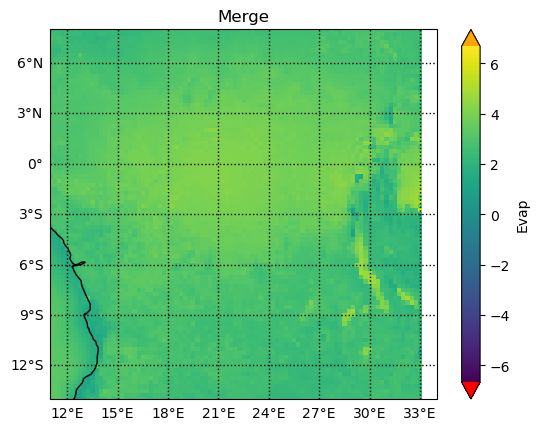

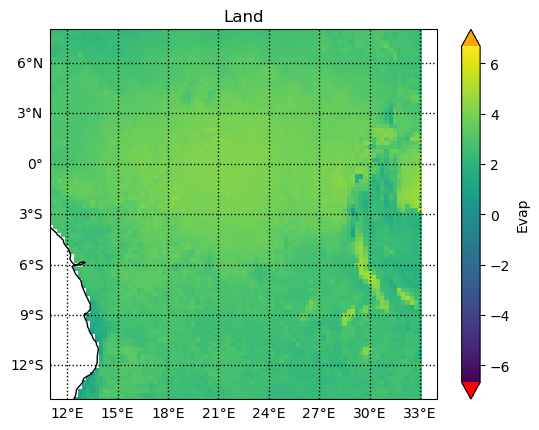

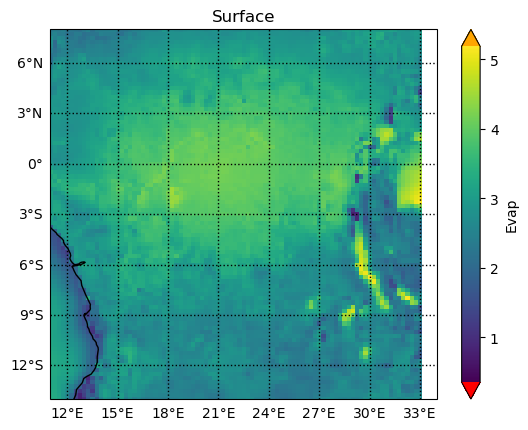

<Figure size 640x480 with 0 Axes>

In [44]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Evap.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Merge')
#plt.savefig()
plt.show()
plt.clf()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Evap_land.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Land')
#plt.savefig()
plt.show()
plt.clf()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Evap_surface.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Surface')
#plt.savefig()
plt.show()
plt.clf()

## Plotting the different Psfc arrays

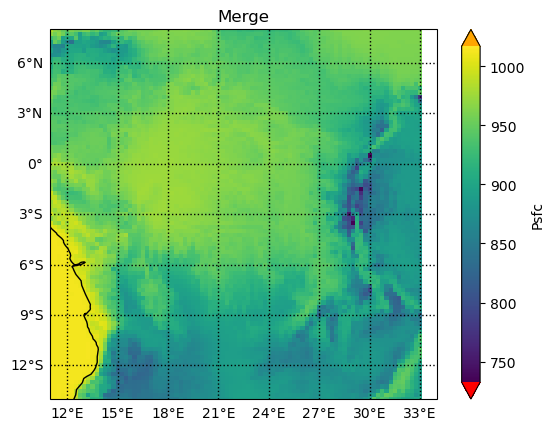

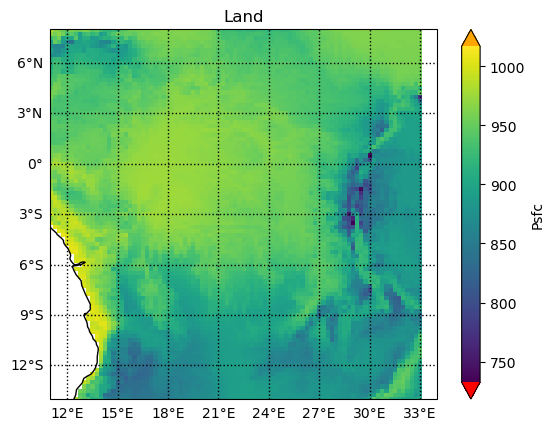

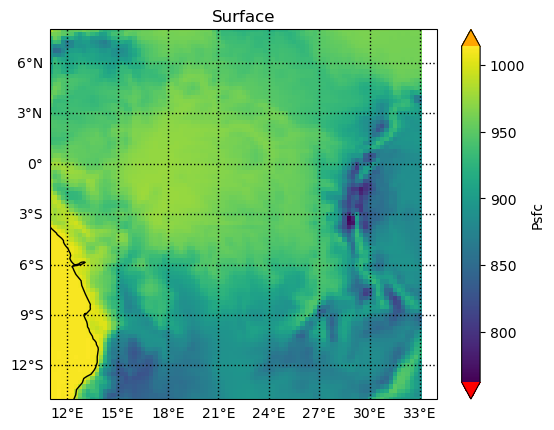

<Figure size 640x480 with 0 Axes>

In [45]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Psfc.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Merge')
#plt.savefig()
plt.show()
plt.clf()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Psfc_land.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Land')
#plt.savefig()
plt.show()
plt.clf()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.OCEAN)
Psfc_surface.mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       alpha=1,
                                       cmap=plt.cm.viridis,
                                       extend="both")
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=1, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Surface')
#plt.savefig()
plt.show()
plt.clf()

**Merging all input datasets into one dataset for recyling code called ds**
- close both input datasets
- sort everything so latitude is south to north
- transpose dimensions so they run (lon,lat,level,time) as in recycling code
- save input ds to file

In [46]:
start = timer.time()
ds = xr.merge([ds_era_pres,Prec,Evap,Psfc]) 
ds_era_pres.close()
ds = ds.sortby('lat', ascending=True)
ds = ds.sel(lat=slice(*lat_bnds_f),lon=slice(*lon_bnds_f))
ds = ds.transpose("lon", "lat", "level", "time",missing_dims='ignore')

ds.to_netcdf(datao+"erads_"+str(YR)+".nc", mode='w', format='NETCDF4', engine='netcdf4')
end = timer.time()
length = end - start
print("Merging and dataset output took ", length, "seconds")

Merging and dataset output took  0.6670310497283936 seconds


**Integrate zonal and meridional moisture flux**
- ***To do:*** do this with hourly data to test difference in rho

In [47]:
#Prepping datasets near surface for recycling
import bulk_recycling_model.numerical_integration

# Integrate 10^-3 Shum Uwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Uwnd"]
Fx = bulk_recycling_model.numerical_integration.integrate_with_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

# Integrate 10^-3 Shum Vwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Vwnd"]
Fy = bulk_recycling_model.numerical_integration.integrate_with_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

**Prepare scaled data for recycling code**
- Evaporation and moisture fluxes


In [48]:
# Prepare and scale the data
from bulk_recycling_model import preprocess
from bulk_recycling_model.axis import Axis
from bulk_recycling_model.scaling import Scaling, UnitSystem

# degrees
L = ds.coords["lon"].max().item() - ds.coords["lon"].min().item()
# convert to meters
L = L * 111e3 * np.cos(np.deg2rad(ds.coords["lat"].mean().item()))
dx = L / ds.sizes["lon"]

# lon axis
lon_axis = Axis(
    ds.coords["lon"].min().item(),
    ds.coords["lon"].diff("lon").mean().item(),
    ds.sizes["lon"],
)

# degrees
H = ds.coords["lat"].values[-1] - ds.coords["lat"].values[0]
# convert to meters
H = H * 111e3
dy = H / ds.sizes["lat"]

# lat axis
lat_axis = Axis(
    ds.coords["lat"].min().item(),
    ds.coords["lat"].diff("lat").mean().item(),
    ds.sizes["lat"],
)

print(f"{L = :.2e} m")
print(f"{dx = :.2e} m")
print(f"{H = :.2e} m")
print(f"{dy = :.2e} m")

# make a scaling object to convert between unit systems
scaling = Scaling(H)

dx = scaling.distance.convert(dx, UnitSystem.SI, UnitSystem.scaled)
dy = scaling.distance.convert(dy, UnitSystem.SI, UnitSystem.scaled)
print(f"{dx = :.2e} scaled")
print(f"{dy = :.2e} scaled")

# convert Fx and Fy to scaled units
Fx = scaling.water_vapor_flux.convert(Fx.values, UnitSystem.natural, UnitSystem.scaled)
Fy = scaling.water_vapor_flux.convert(Fy.values, UnitSystem.natural, UnitSystem.scaled)

# convert E to scaled units
#print('pre-scaled',ds['Evap'])
E = scaling.evaporation.convert(ds["Evap"].values, UnitSystem.natural, UnitSystem.scaled)

L = 2.44e+06 m
dx = 2.74e+04 m
H = 2.78e+06 m
dy = 2.75e+04 m
dx = 9.88e-03 scaled
dy = 9.90e-03 scaled


**Run recycling model for each timestep**
- Create recycling output array based on the shape of one of the surface input files: evap 
- Translate evap and fluxes to secondary grid
- Calculate modeled precipitation
- Plot scaled input variables (evap and fluxes)
- Run through each timestep in the input files and calculate recycling ratio at each timestep across domain
- Plot rho and convergence metric for each timestep

INFO:bulk_recycling_model.main:Converged in 329 iterations and 0:00:07.380951


0 2000-01-01T00:00:00.000000000
329


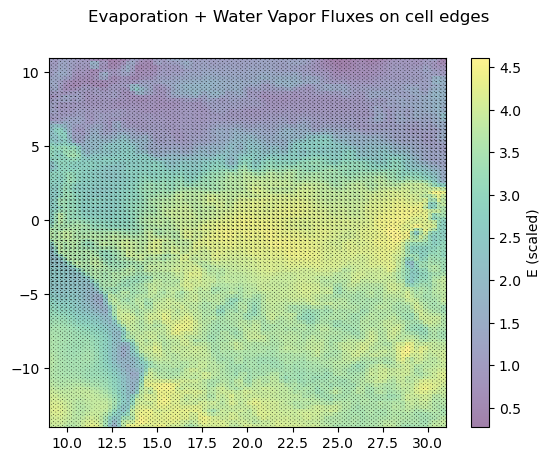

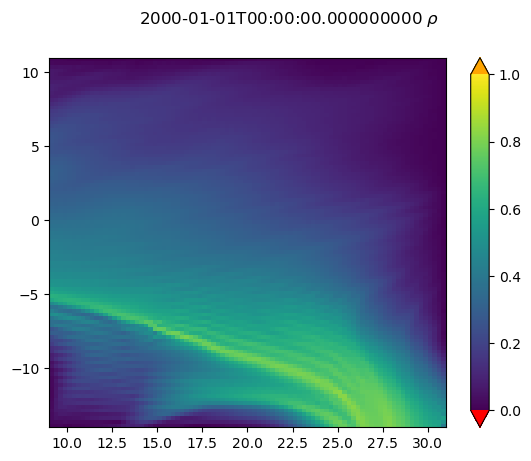

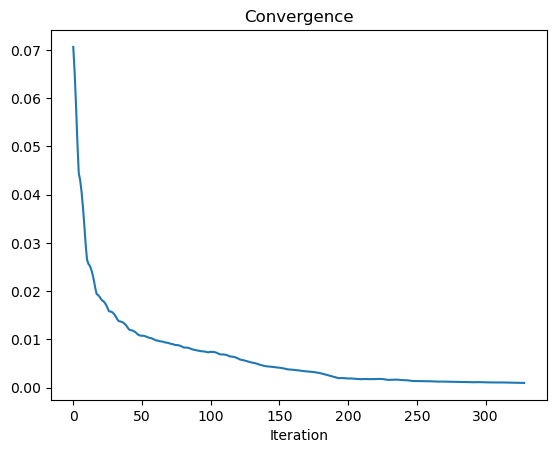

INFO:bulk_recycling_model.main:Converged in 406 iterations and 0:00:09.017592


1 2000-02-01T00:00:00.000000000
406


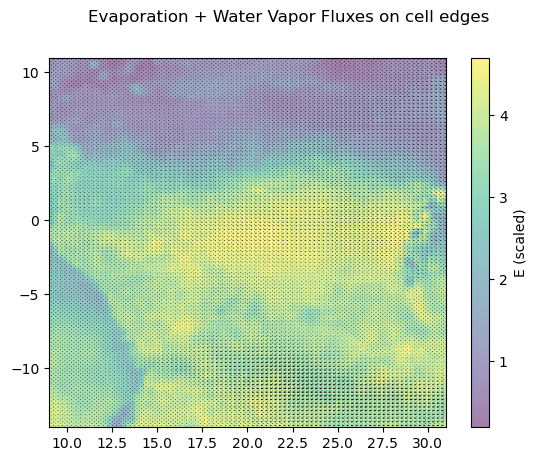

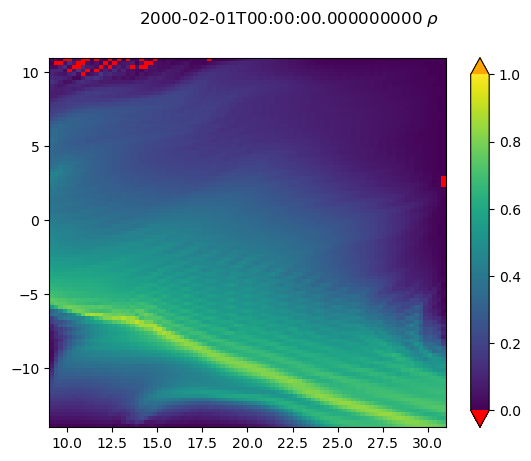

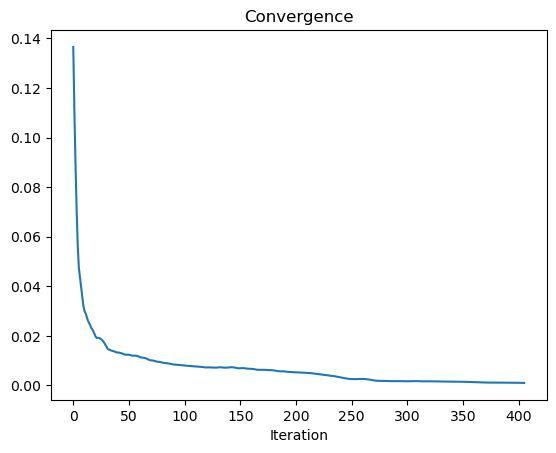

INFO:bulk_recycling_model.main:Converged in 309 iterations and 0:00:06.872528


2 2000-03-01T00:00:00.000000000
309


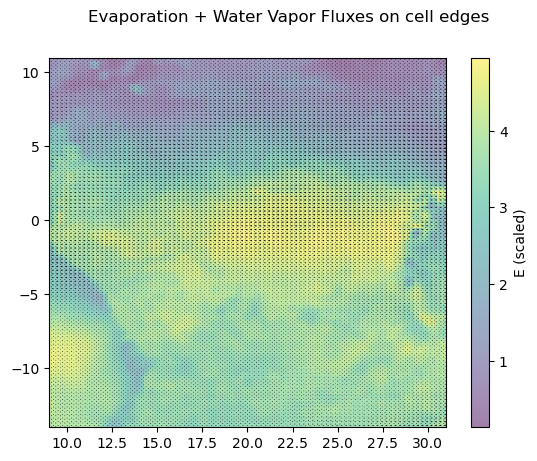

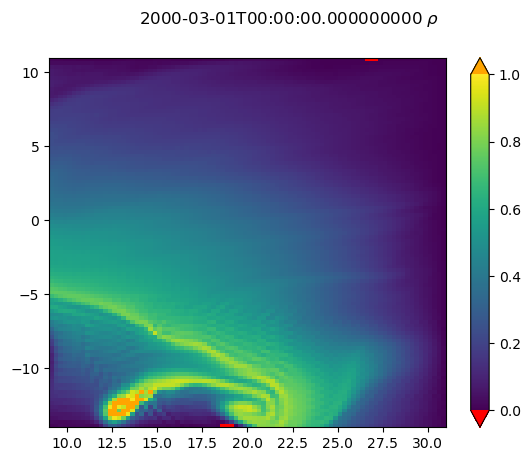

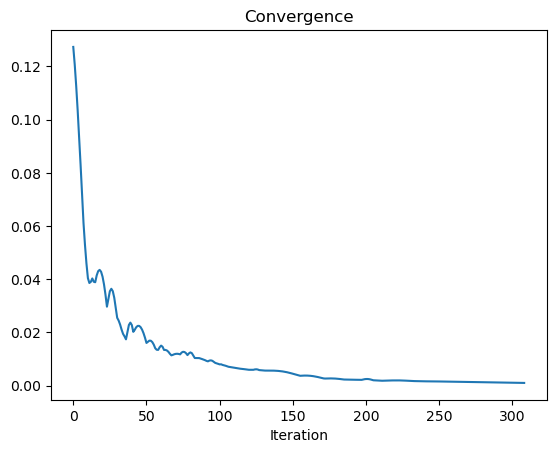

INFO:bulk_recycling_model.main:Converged in 305 iterations and 0:00:06.863525


3 2000-04-01T00:00:00.000000000
305


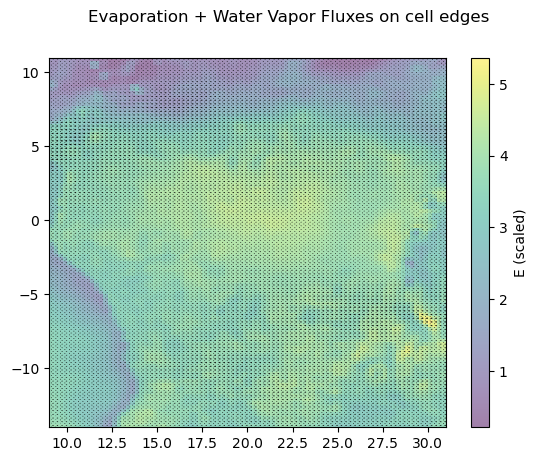

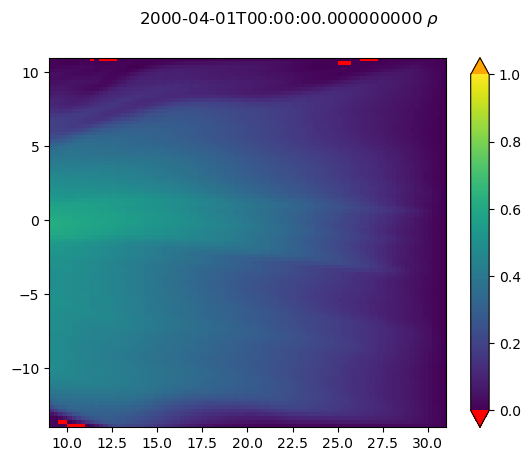

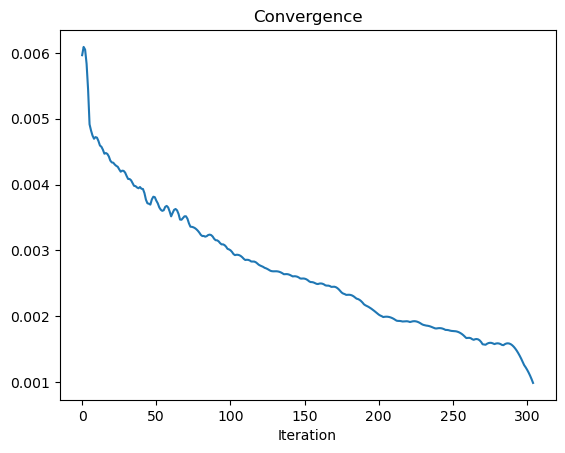

INFO:bulk_recycling_model.main:Converged in 385 iterations and 0:00:08.621845


4 2000-05-01T00:00:00.000000000
385


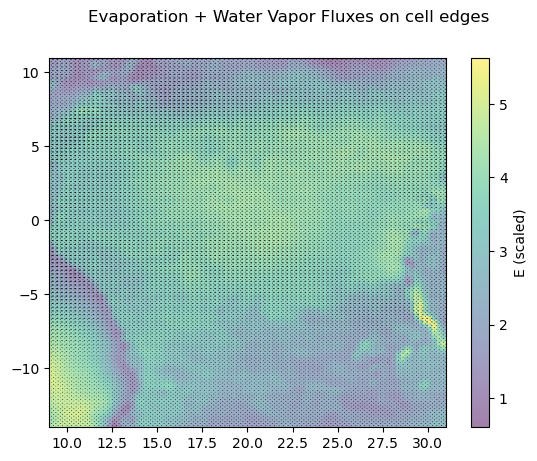

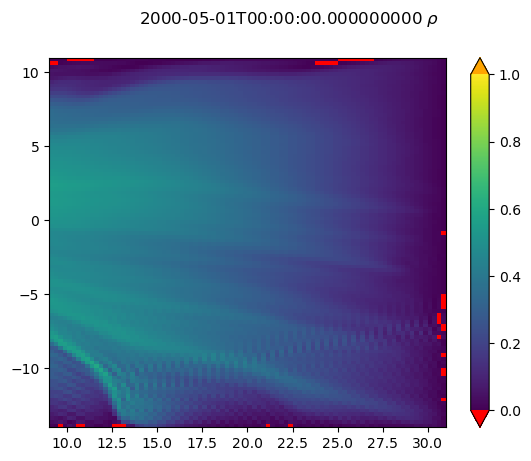

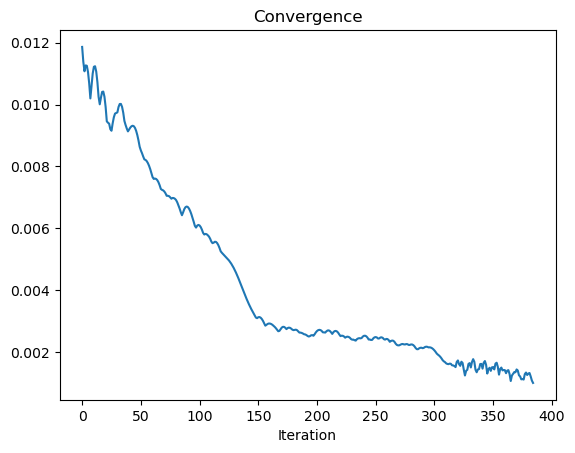

5 2000-06-01T00:00:00.000000000
1000


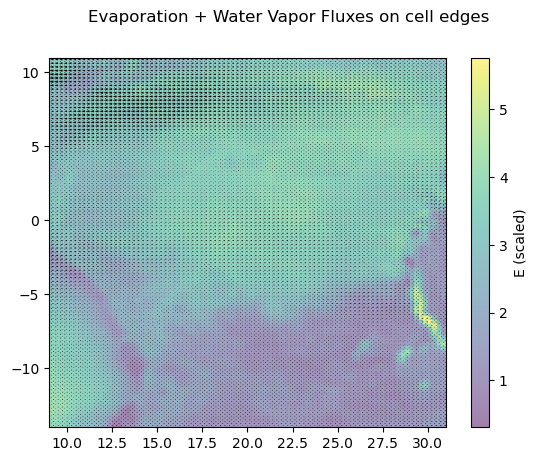

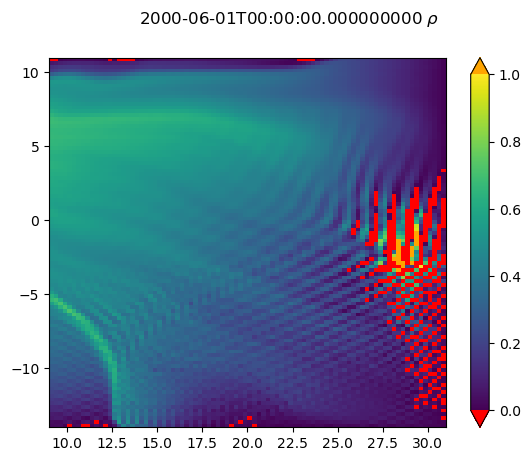

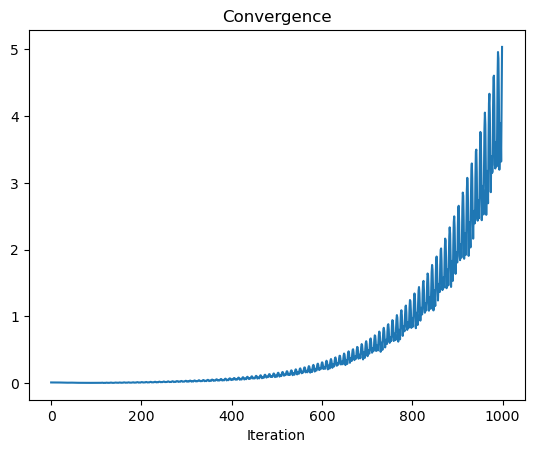

6 2000-07-01T00:00:00.000000000
1000


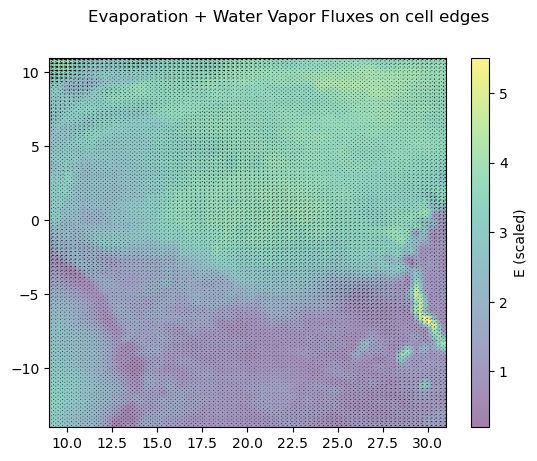

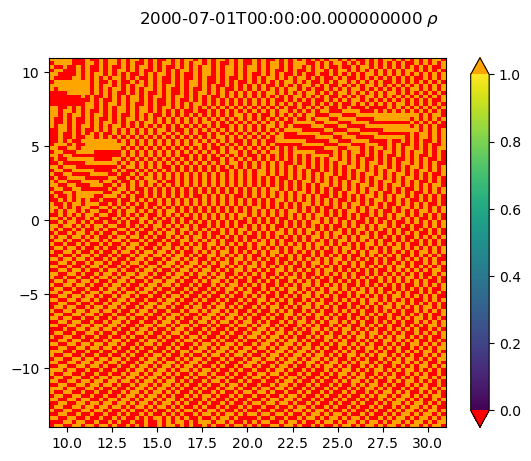

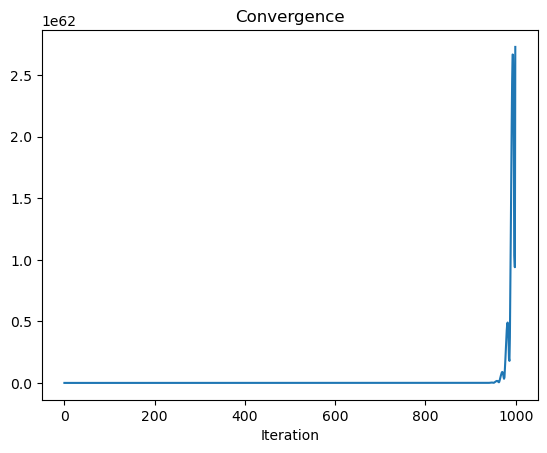

7 2000-08-01T00:00:00.000000000
1000


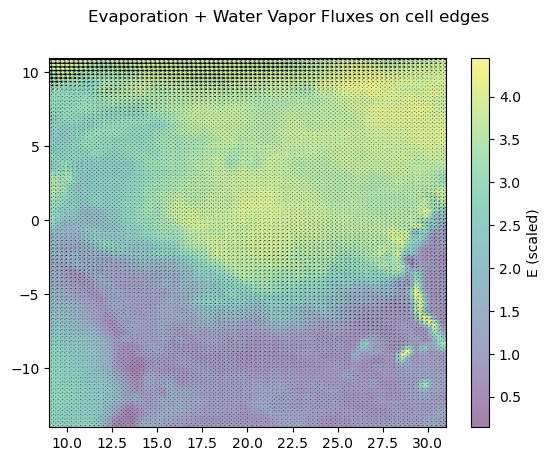

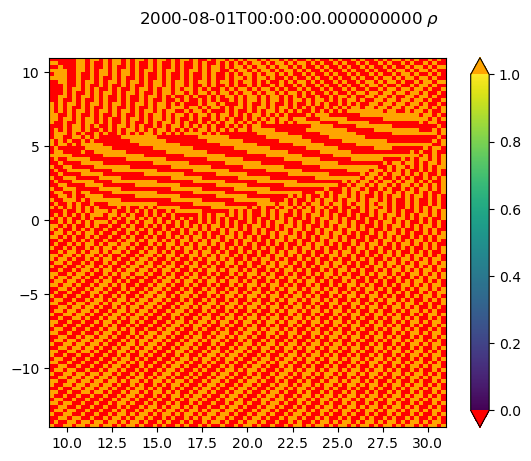

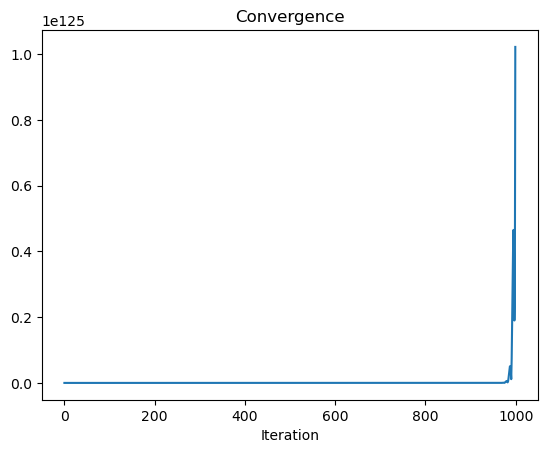

INFO:bulk_recycling_model.main:Converged in 314 iterations and 0:00:07.042447


8 2000-09-01T00:00:00.000000000
314


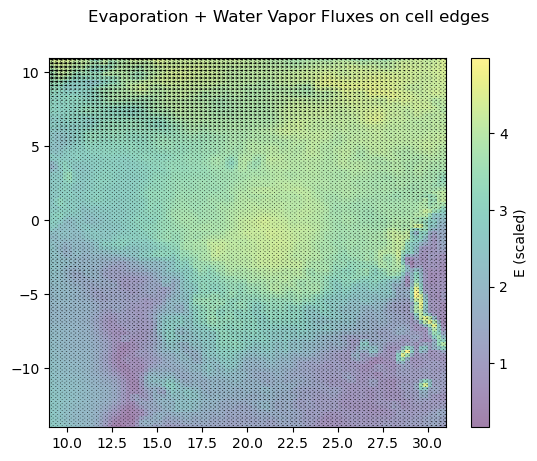

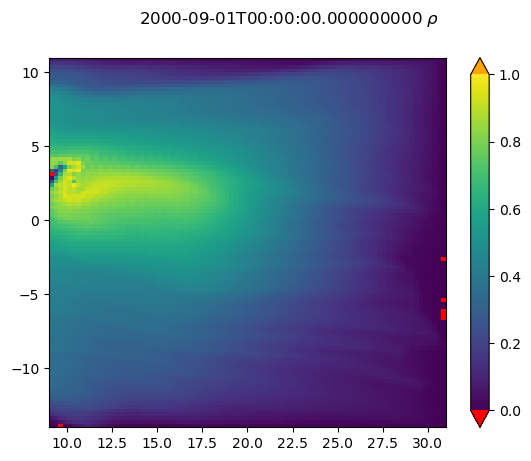

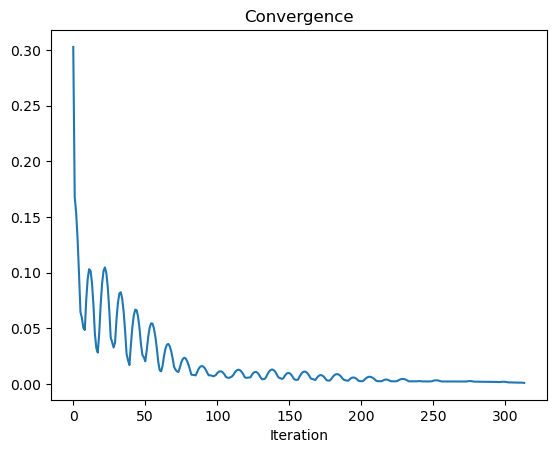

INFO:bulk_recycling_model.main:Converged in 338 iterations and 0:00:07.320762


9 2000-10-01T00:00:00.000000000
338


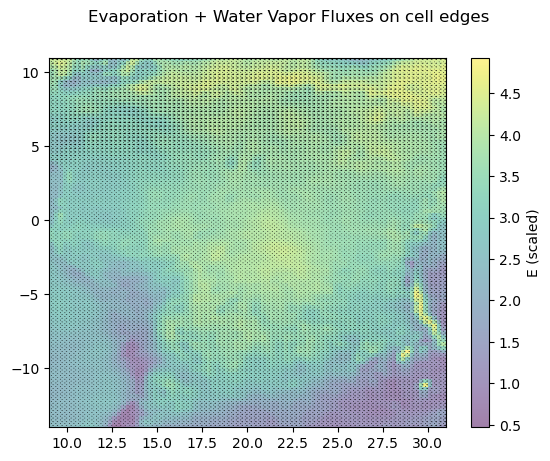

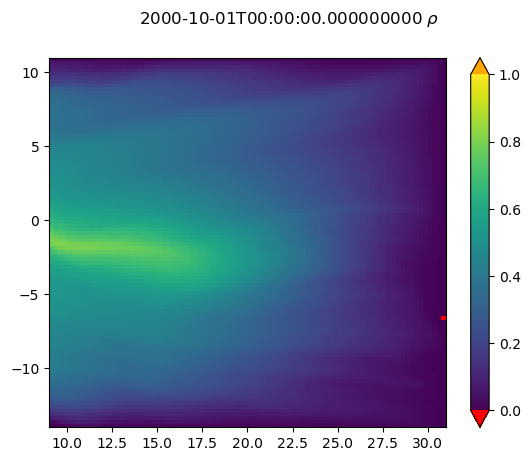

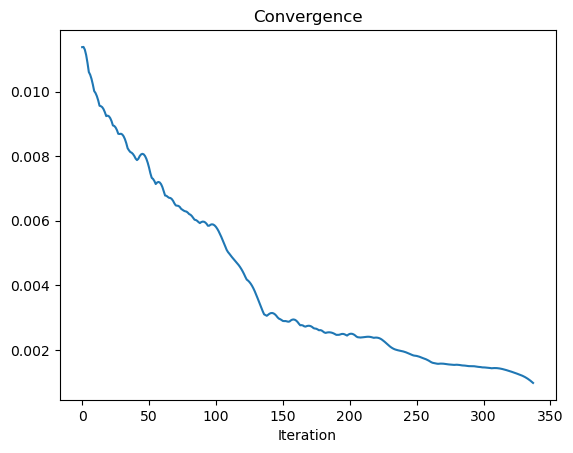

10 2000-11-01T00:00:00.000000000
1000


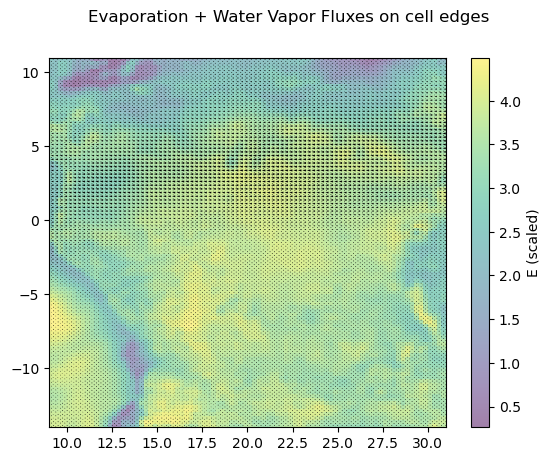

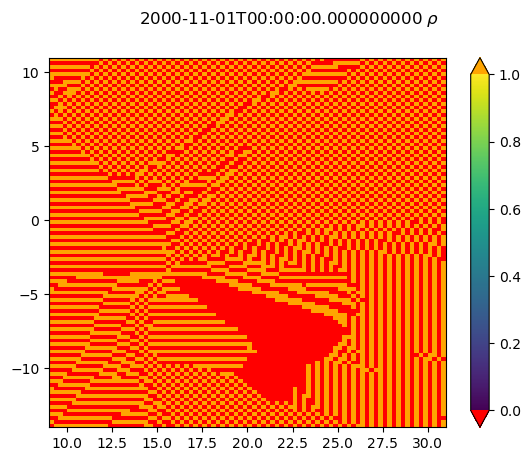

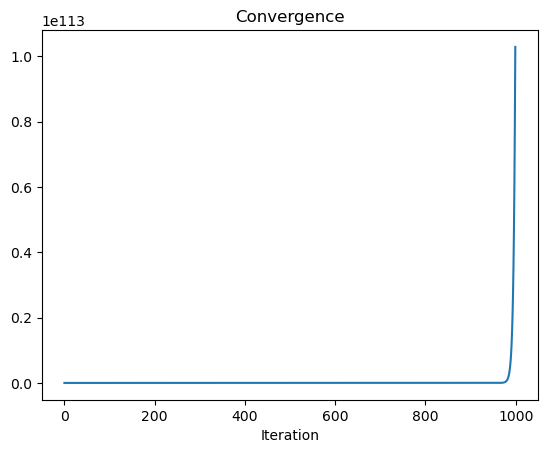

INFO:bulk_recycling_model.main:Converged in 330 iterations and 0:00:07.480174


11 2000-12-01T00:00:00.000000000
330


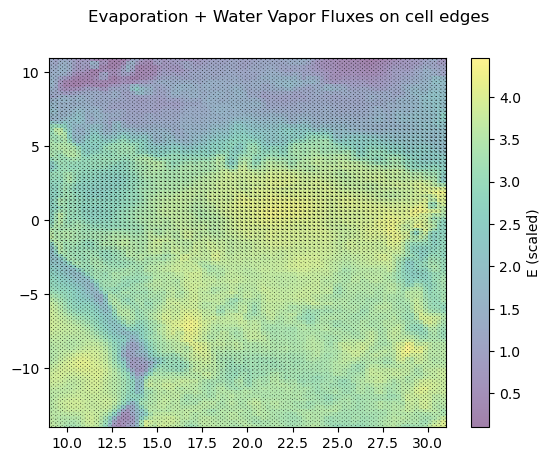

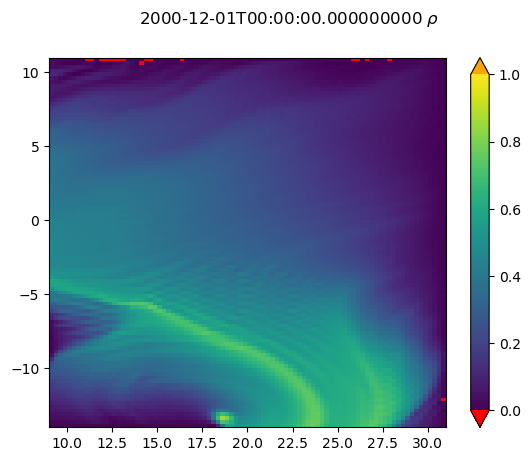

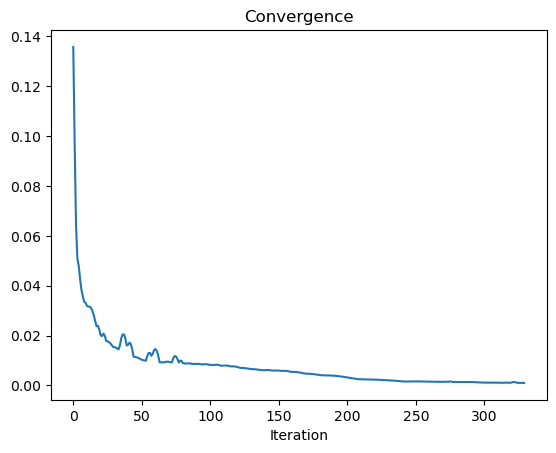

In [49]:
import matplotlib.pyplot as plt
import logging
logging.basicConfig()
logging.getLogger("bulk_recycling_model").setLevel(logging.INFO)
from bulk_recycling_model import plotting
from bulk_recycling_model.main import run

rho_ar = np.empty((np.shape(E)[0]-1,np.shape(E)[1]-1,np.shape(E)[2]))
#Entering preprocessing and time step loop
#Run model and plot
for i,time in enumerate(ds.time):
     
    # preprocess E onto the secondary grid
    Ei = preprocess.prepare_E(E[:,:,i])
    
    # preprocess water vapor fluxes onto the secondary grid
    Fxi_left = preprocess.prepare_Fx_left(Fx[:,:,i])
    Fxi_right = preprocess.prepare_Fx_right(Fx[:,:,i])
    Fyi_bottom = preprocess.prepare_Fy_bottom(Fy[:,:,i])
    Fyi_top = preprocess.prepare_Fy_top(Fy[:,:,i])
    
    # compute P
    Pi = preprocess.calculate_precipitation(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, Ei, dx, dy)
    
    ## Create a quiver plot
    #fig, ax = plt.subplots()
    #U,V = plotting.build_uv_fluxes(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top)
    #X, Y = np.meshgrid(lon_axis.half_step, lon_axis.half_step, indexing="ij")
    #ax.quiver(X[::3, ::3],Y[::3, ::3],U[::3, ::3],V[::3, ::3])
    #fig.suptitle("Water Vapor Fluxes on cell edges")
    
    # Create a quiver plot
    fig, ax = plt.subplots()
    collection = plotting.pcolormesh(ax, Ei, lon_axis, lat_axis, alpha=0.5)
    fig.colorbar(collection, label="E (scaled)")
    plotting.quiver(ax, Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, lon_axis, lat_axis)
    fig.suptitle("Evaporation + Water Vapor Fluxes on cell edges")
    
    # Run the model
    status = run(
        Fxi_left,
        Fxi_right,
        Fyi_bottom,
        Fyi_top,
        Ei,
        Pi,
        dx,
        dy,
        R=0.2,
        R_1=0.2,
        max_iter=1000,
        tol=1e-3,
    )
    
    #Print timestep and status (converged or not) and add rho to recycling ration array
    print(i,time.values)
    print(status['k'])
    rho_ar[:,:,i] = status["rho"]
    
    # plot each timestep 
    fig, ax = plt.subplots()
    cmap=plt.cm.viridis
    cmap.set_extremes(under='red', over='orange')
    collection = plotting.pcolormesh(ax, status["rho"], lon_axis, lat_axis,
                                     vmin=0.0, vmax=1,
                                     cmap=cmap)
    fig.colorbar(collection,extend='both')
    fig.suptitle(str(time.values)+" $\\rho$")
    #plt.savefig(datap+"rho_"+str(time.values)+".png")
    plt.show()
    plt.close()
    
    # plot the convergence
    deltas = status["deltas"]
    fig, ax = plt.subplots()
    ax.plot(deltas)
    ax.set_title("Convergence")
    ax.set_xlabel("Iteration")
    plt.show()
    plt.close()

**Create and save rho xarray file**

- Create an xarray to store all of the calculated recycling ratios that is organised in an easy to plot/interpret format
- Count number of values in array over 1 - replace all of these with 1
- Count number of negative rho values - replace all of these with zero
- Save to file

In [50]:
lon_ar = np.linspace(start=ds.coords["lon"].min().values+lon_axis.step/2,
                     stop=ds.coords["lon"].max().values-lon_axis.step/2,
                     num=lon_axis.n_points-1)
lat_ar = np.linspace(start=ds.coords["lat"].min().values+lat_axis.step/2,
                     stop=ds.coords["lat"].max().values-lat_axis.step/2,
                     num=lat_axis.n_points-1)
rho_xarr = xr.Dataset(
    data_vars=dict(rho=(["lon","lat","time"],rho_ar)),
    coords=dict(
        lon=(["lon"], lon_ar),
        lat=(["lat"], lat_ar),
        time=(["time"],ds.time.data)
    ),
    attrs=dict(
        description="Recycling ratio",
        units="%",
    ),
) 
rho_xarr = rho_xarr.transpose("time","lat","lon")
rho_xarr.to_netcdf(datao+"merge_rho_era5_"+str(YR)+".nc")

In [51]:
#Filtering out outliers for plotting 

print('Number of rhos over 1: ', rho_xarr['rho'].where(rho_xarr['rho'].values>1.0).count().values)
print('Number of negative rhos: ', rho_xarr['rho'].where(rho_xarr['rho'].values<0.0).count().values)
rho_xarr = rho_xarr.where(rho_xarr['rho'].values<=1.0,1.0)
rho_xarr = rho_xarr.where(rho_xarr['rho'].values>0.0,0.0)
print('Number of rhos over 1: ', rho_xarr['rho'].where(rho_xarr['rho'].values>1.0).count().values)
print('Number of negative rhos: ', rho_xarr['rho'].where(rho_xarr['rho'].values<0.0).count().values)
end_all = timer.time()
length = end_all - start_all
print("Running the whole prep and recycling code took ", length, "seconds")


Number of rhos over 1:  13024
Number of negative rhos:  13895
Number of rhos over 1:  0
Number of negative rhos:  0
Running the whole prep and recycling code took  1741.9564001560211 seconds


**Plotting**

Create seasonal arrays and plot these

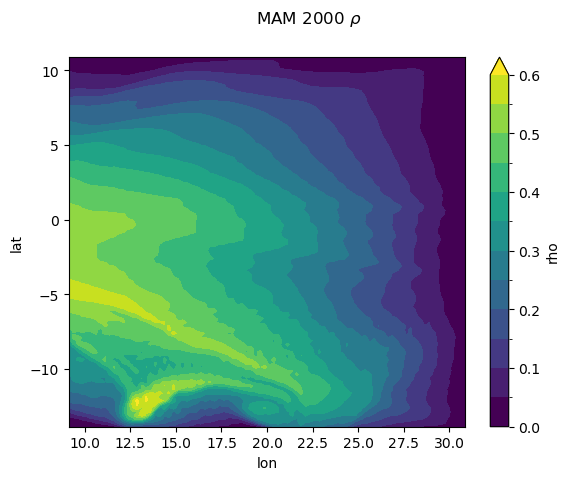

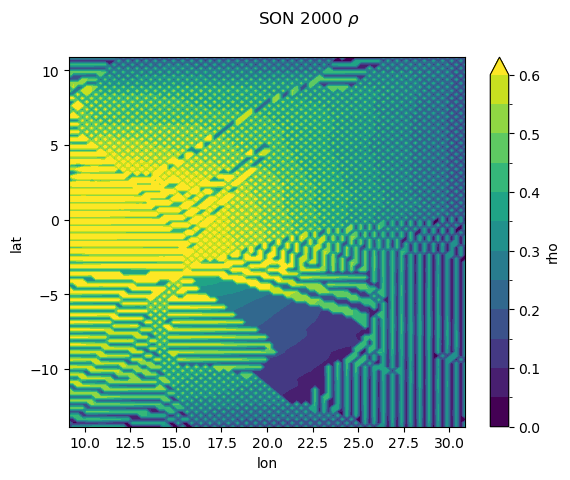

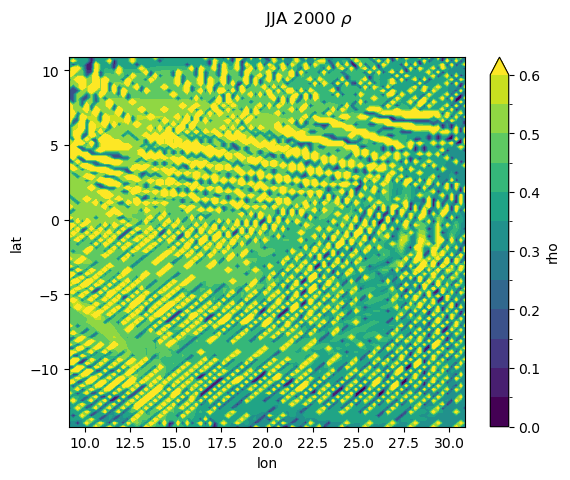

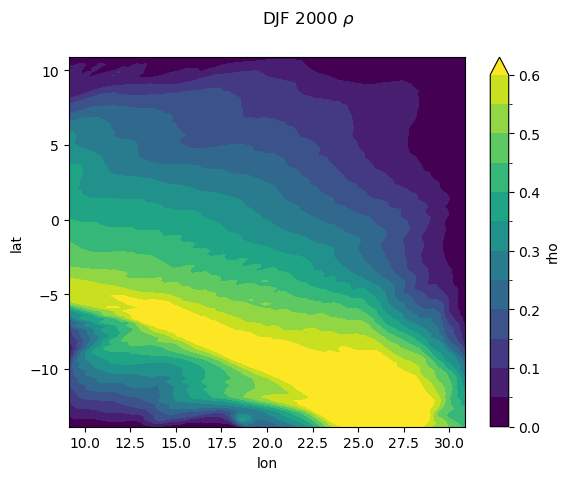

In [52]:

mam_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([3,4,5]))
fig, ax = plt.subplots()
collection = mam_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("MAM "+str(YR)+" $\\rho$")
#plt.savefig(datao+"rho_MAM_"+str(YR)+".png")
plt.show()
    
son_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([9,10,11]))
fig, ax = plt.subplots()
collection = son_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("SON "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_SON_"+str(YR)+".png")
plt.show()

jja_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([6,7,8]))
fig, ax = plt.subplots()
collection = jja_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("JJA "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_JJA_"+str(YR)+".png")
plt.show()

djf_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([12,1,2]))
fig, ax = plt.subplots()
collection = djf_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("DJF "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_DJF_"+str(YR)+".png")
plt.show()

rho_xarr.close()

